In [2]:
!pip install pykan
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 3.4 MB/s eta 0:00:00
cpu
checkpoint directory created: ./model
saving model version 0.0


In [3]:
from kan.utils import create_dataset
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

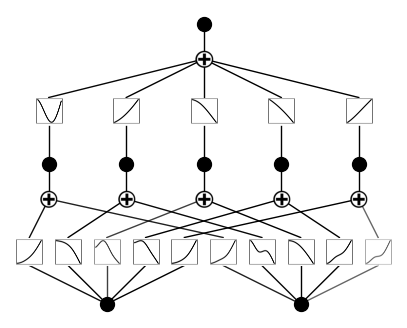

In [4]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot()

In [5]:
# train the model
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

| train_loss: 1.84e-02 | test_loss: 1.76e-02 | reg: 5.83e+00 | : 100%|█| 50/50 [00:32<00:00,  1.56it

saving model version 0.1


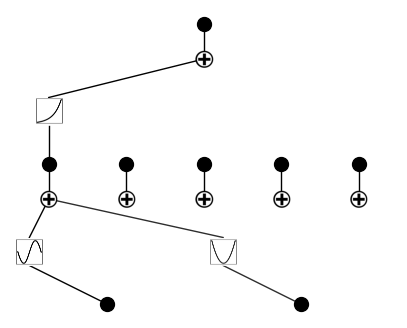

In [6]:
model.plot()

saving model version 0.2


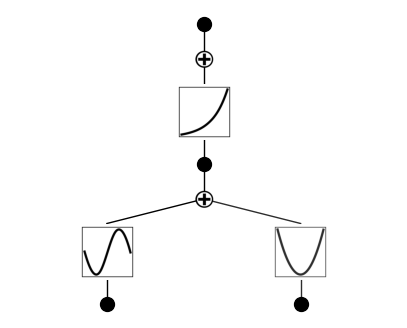

In [7]:
model = model.prune()
model.plot()

In [8]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 1.78e-02 | test_loss: 1.70e-02 | reg: 8.04e+00 | : 100%|█| 50/50 [00:12<00:00,  4.04it

saving model version 0.3


In [9]:
model = model.refine(10)

saving model version 0.4


In [10]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 4.66e-04 | test_loss: 4.72e-04 | reg: 8.00e+00 | : 100%|█| 50/50 [00:13<00:00,  3.79it

saving model version 0.5


In [11]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999999195639321, c=2
fixing (0,1,0) with x^2, r2=0.9999999811102847, c=2
fixing (1,0,0) with exp, r2=0.9999999908055064, c=2
saving model version 0.6


In [12]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 5.87e-11 | test_loss: 3.21e-11 | reg: 0.00e+00 | : 100%|█| 50/50 [00:03<00:00, 12.56it

saving model version 0.7


In [13]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],4)

/usr/local/lib/python3.12/dist-packages/sympy/core/sympify.py:449: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return sympify(float(a))


1.0*exp(1.0*x_2**2 + 1.0*sin(3.1416*x_1))